# Convert from mirage22 to csv

In [ ]:
import csv
import os
import json

def convert_file(filename, to_file):
    fields = ['five-tuple', 'timestamp','iat', 'packet_size']
    with open(filename) as f:
        d = json.load(f)
        with open(to_file, 'w+',newline='') as csvfile:  
            csvwriter = csv.writer(csvfile)
            csvwriter.writerow(fields)  
            for _,key in enumerate(d):
                length = len(d[key]['packet_data']['timestamp'])
                for i in range(length):
                    csvwriter.writerow([key, d[key]['packet_data']['timestamp'][i], d[key]['packet_data']['iat'][i], d[key]['packet_data']['IP_packet_bytes'][i]])

def process_files(directory_path, new_dir_path):
    # List all files in the directory
    files = os.listdir(directory_path)

    i = 0
    # Iterate through each file and call the funcvtion
    for file in files:
        file_path = os.path.join(directory_path, file)

        # Check if it's a file (not a directory)
        if os.path.isfile(file_path):
            convert_file(file_path, os.path.join(new_dir_path, str(i)+".csv"))
            i += 1

process_files(r"data\MIRAGE-COVID-CCMA-2022\MIRAGE-COVID-CCMA-2022\Raw_JSON\Discord\Discord", r"data\discord_data\\")

# Read PCAP and resample to bin by 250ms

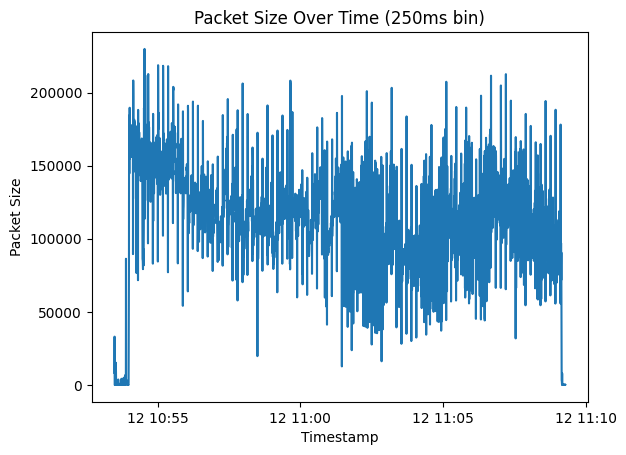

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv(r"data\discord_data\70.csv")
sorted_df = df.sort_values(by='timestamp').drop(columns=['five-tuple', 'iat'])
sorted_df['timestamp'] = pd.to_datetime(sorted_df['timestamp'], unit='s')
df_resampled = sorted_df.set_index('timestamp').resample('250L').sum()

plt.plot(df_resampled.index, df_resampled['packet_size'])
plt.xlabel('Timestamp')
plt.ylabel('Packet Size')
plt.title('Packet Size Over Time (250ms bin)')
plt.show()

In [39]:
max_t = df['timestamp'].max()
min_t = df['timestamp'].min()
max_t - min_t

947.8024361133575

In [40]:
df['normalized_timestamp'] = df['timestamp'] - df['timestamp'].min()

In [41]:
df['normalized_timestamp']

0           0.000000
1           0.022107
2           0.032095
3           0.035995
4           1.884993
             ...    
436456    934.843572
436457    934.886429
436458    941.710431
436459    941.729972
436460    941.737428
Name: normalized_timestamp, Length: 436461, dtype: float64

# Selecting 10 random files and displaying their flow

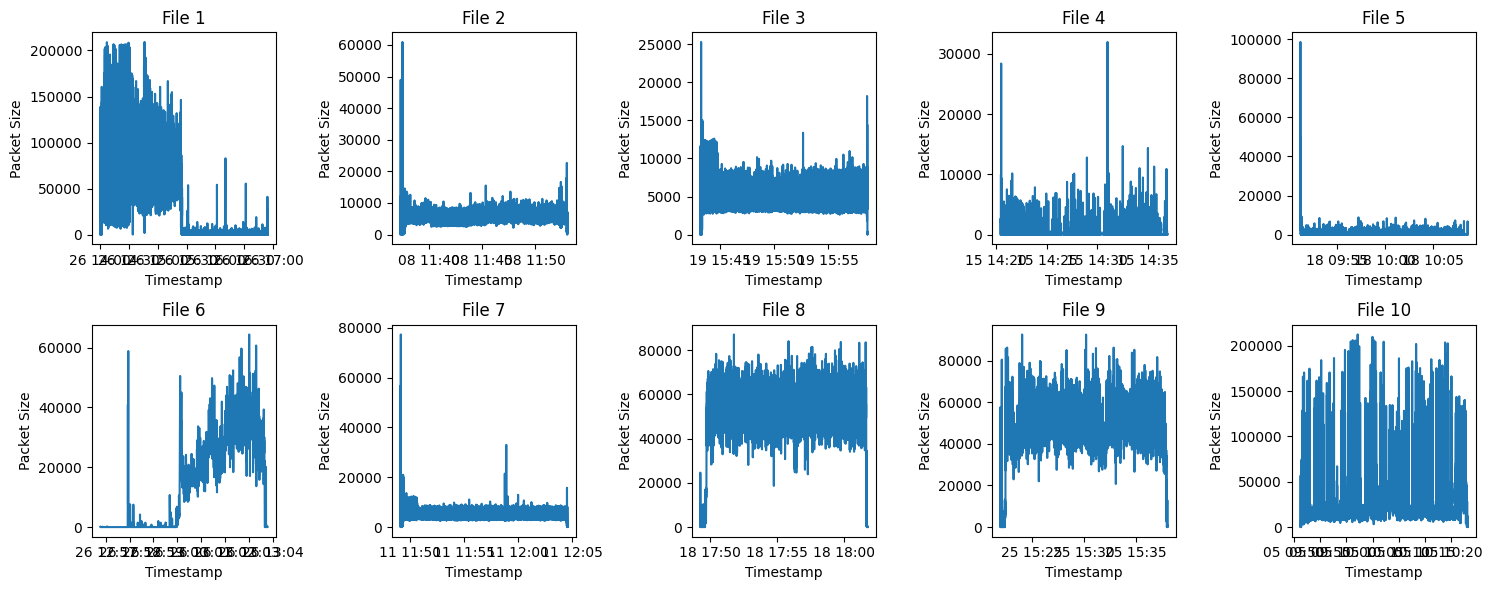

In [53]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from random import sample

# Function to read and resample a CSV file
def read_and_resample_csv(file_path):
    df = pd.read_csv(file_path)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    sorted_df = df.sort_values(by='timestamp').drop(columns=['five-tuple', 'iat'])
    df_resampled = sorted_df.set_index('timestamp').resample('250L').sum()
    return df_resampled

# Directory containing CSV files
data_directory = 'data\\teams_data'

# List all CSV files in the directory
csv_files = list(Path(data_directory).rglob('*.csv'))

# Select 10 random files
random_files = sample(csv_files, 10)

# Create a 2x5 grid of subplots
fig, axs = plt.subplots(2, 5, figsize=(15, 6))

# Iterate over the random files and plot them
for i, file_path in enumerate(random_files):
    row, col = divmod(i, 5)  # Calculate the row and column index
    df_resampled = read_and_resample_csv(file_path)
    axs[row, col].plot(df_resampled.index, df_resampled['packet_size'])
    axs[row, col].set_title(f'File {i + 1}')
    axs[row, col].set_xlabel('Timestamp')
    axs[row, col].set_ylabel('Packet Size')

    # axs[1, col].plot(df_resampled.index, df_resampled['iat']/)
    # axs[1, col].set_title(f'File {i + 1}')
    # axs[1, col].set_xlabel('Timestamp')
    # axs[1, col].set_ylabel('IAT')

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

# Attempting to recreate the FlowPics

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to create a FlowPic from a CSV file
def create_flowpic(csv_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Filter out packets with size greater than 1500
    df = df[df['packet_size'] <= 1500]

    # Normalize time of arrival values
    df['normalized_timestamp'] = df['timestamp'] - df['timestamp'].min()
    # df = df[(df['normalized_timestamp'] < 500) & (df['normalized_timestamp'] > 15)]
    
    # Normalize time of arrival values to be between 0 and 1500
    max_time = 1500
    df['normalized_timestamp'] = (df['normalized_timestamp'] / df['normalized_timestamp'].max()) * max_time

    plt.figure()
    plt.scatter(df['normalized_timestamp'], df['packet_size'], marker=',', c='k', s=5)

    # Plot the FlowPic
    # plt.imshow(histogram.T, origin='lower', extent=[0, max_time, 1, 1500], aspect='auto', cmap='viridis')
    plt.xlabel('Normalized Time of Arrival')
    plt.ylabel('Packet Size')
    plt.title('FlowPic')
    plt.set_cmap('binary')
    # plt.axes().set_aspect('equal')
    plt.show()

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to create a FlowPic from a CSV file
def create_flowpic(csv_file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(csv_file_path)

    # Filter out packets with size greater than 1500
    df = df[df['packet_size'] <= 1500]

    # Normalize time of arrival values
    df['normalized_timestamp'] = df['timestamp'] - df['timestamp'].min()

    # # Normalize time of arrival values to be between 0 and 1500
    # max_time = 1500
    # df['normalized_timestamp'] = (df['normalized_timestamp'] / df['normalized_timestamp'].max()) * max_time

    # Create subplots for each 60s interval
    interval_size = 60
    num_intervals = int(df['normalized_timestamp'].max() / interval_size)
    
    fig, axs = plt.subplots(num_intervals, 1, figsize=(10, 5*num_intervals))

    for i in range(num_intervals):
        interval_start = i * interval_size
        interval_end = (i + 1) * interval_size

        interval_df = df[(df['normalized_timestamp'] >= interval_start) & (df['normalized_timestamp'] < interval_end)]
        interval_df['normalized_timestamp'] = (interval_df['normalized_timestamp']-interval_df['normalized_timestamp'].min())/(interval_df['normalized_timestamp'].max()-interval_df['normalized_timestamp'].min())
        interval_df['normalized_timestamp'] = interval_df['normalized_timestamp'] * 1400
        axs[i].scatter(interval_df['normalized_timestamp'], interval_df['packet_size'], marker=',', c='k', s=5)
        axs[i].set_xlabel('Normalized Time of Arrival')
        axs[i].set_ylabel('Packet Size')
        axs[i].set_title(f'FlowPic - Interval {i + 1}')
        axs[i].set_aspect('equal')
    
    plt.tight_layout()
    plt.show()

C:\Users\nathaniel\AppData\Local\Temp\ipykernel_20640\1176267039.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_df['normalized_timestamp'] = (interval_df['normalized_timestamp']-interval_df['normalized_timestamp'].min())/(interval_df['normalized_timestamp'].max()-interval_df['normalized_timestamp'].min())
C:\Users\nathaniel\AppData\Local\Temp\ipykernel_20640\1176267039.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interval_df['normalized_timestamp'] = interval_df['normalized_timestamp'

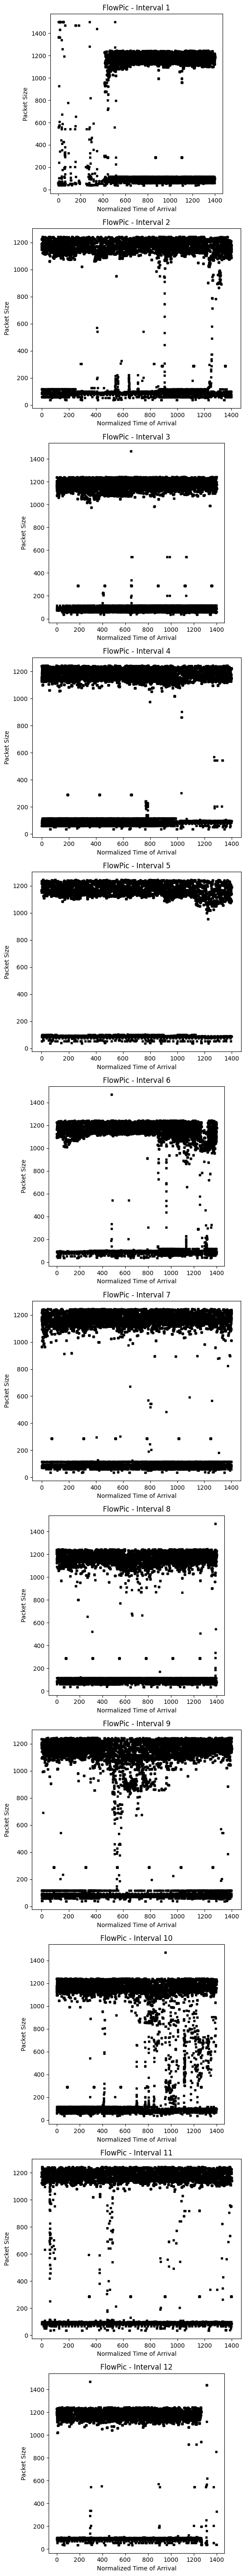

In [8]:
create_flowpic(r'data\discord_data\6.csv')